In [1]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(0, '..')
from sc import *
import matplotlib.pyplot as plt
import matplotlib
from alg import hstar, k_rollout, almost_equal, bhattacharya
from plot import plot_path, several_path_plot, plot_sc
from pqdict import pqdict

In [13]:
hole_locs = [
       [ 2.77555756e-17,  5.55555556e-02],
       [-4.00000000e-01,  0.00000000e+00],
       [ 2.77555756e-17,  5.55555556e-01],
       [ 6.00000000e-01, -4.44444444e-02],
       [ 2.00000000e-01, -6.44444444e-01],
       [ 5.00000000e-01,  4.55555556e-01],
       [-7.00000000e-01, -5.00000000e-01],
       [-5.00000000e-01,  6.55555556e-01],
       [ 7.00000000e-01, -5.44444444e-01],
       [-2.50000000e-01, -7.00000000e-01]]

hole_locs = np.array(hole_locs)

In [7]:
SC = SimplicialComplex(18, False, False, True)
SC.make_holes([hole_locs[0]],  0.12)

In [211]:
import time

def bhattacharya2(SC, ref_path, start, end, eps=1e-6, others=False, verbose=False, get_time=False):
    start_time = time.time()
    vec_dist = lambda x, y: np.linalg.norm(np.array(x)-np.array(y))
    heuristic = lambda u, v: vec_dist(SC.nodes[u], SC.nodes[v])
    ref_proj, zero_proj = tuple(ref_path.proj), tuple(np.zeros_like(ref_path.proj))

    pq = pqdict()
    pq[(start, 0)] = heuristic(start, end)

    prev = {(start,0):-1}
    dist = {start:{0:0}}
    visited = {start:set([0])}
    proj_dict = {start:{0:zero_proj}, end:{0:ref_proj}}

    def add_visited(node, proj_idx):
        if node in visited:
            visited[node].add(proj_idx)
        else:
            visited[node] = set([proj_idx])

    def get_proj_idx(node, node_proj):
        if node not in proj_dict:
            idx = 0
            proj_dict[node] = {idx:node_proj}
        elif node in proj_dict:
            idx = max_idx = -1
            for idx_i in proj_dict[node]:
                max_idx = max(max_idx, idx_i)
                if almost_equal(node_proj, proj_dict[node][idx_i]):
                    idx = idx_i
                    break
            if idx < 0:
                idx = max_idx + 1
                proj_dict[node][idx] = node_proj

        return idx

    num_visited = 0
    while True:
        (u, proj_u_idx), est_dist_u = pq.popitem()
        # print(u, proj_u_idx)
        proj_u = proj_dict[u][proj_u_idx]
        dist_u = dist
        dist_u = est_dist_u - heuristic(u, end)
        add_visited(u, proj_u_idx)

        if verbose and (u == end):
            proj_diff_u = vec_dist(proj_u, ref_proj)
            print(f"Found path with projection difference = {np.round(proj_diff_u, 5)} and length  = {np.round(dist[u][proj_u], 1)}")
        if (u == end) and almost_equal(ref_proj, proj_u, eps):
            break
        
        for v in SC.G.neighbors(u):
            uv_edge = Path(SC, [u,v])
            proj_v = np.array(proj_u) + uv_edge.proj
            dist_v_alt = dist_u + uv_edge.weight
            proj_v_idx = get_proj_idx(v, proj_v)  

            if v in visited and proj_v_idx in visited[v]:
                continue

            if v not in dist:
                dist[v] = {proj_v_idx:np.inf}
            elif proj_v_idx not in dist[v]:
                dist[v][proj_v_idx] = np.inf

            if dist_v_alt < dist[v][proj_v_idx]:
                prev[(v, proj_v_idx)] = (u, proj_u_idx)
                dist[v][proj_v_idx] = dist_v_alt
                pq[v, proj_v_idx] = dist_v_alt + heuristic(v, end)
        num_visited += 1


    def backtrace2(prev, start, end, ref_proj_idx, others):
        u, u_proj_idx = end, ref_proj_idx

        path = []
        while (u, u_proj_idx) != (start, 0):
            path = [u] + path
            (u, u_proj_idx) = prev[(u, u_proj_idx)]
        path = Path(SC, [u] + path)

        if not others:
            return path
        
        others_proj_idx = [x for x in proj_dict[end].keys() if x != ref_proj_idx]
        other_paths = [backtrace2(prev, start, end, x, False) for x in others_proj_idx]

        return path, other_paths

    elapsed_time = time.time() - start_time

    if get_time:
        return backtrace2(prev, start, end, 0, others), num_visited, elapsed_time
    else:
        return backtrace2(prev, start, end, 0, others)

In [216]:
ref_path = path_from_coords(SC, [(-1, -1), (-1, 1), (1,1)])
bhat = bhattacharya2(SC, ref_path, ref_path[0], ref_path[-1], others=True)
h, _, _, _, _  = hstar(SC, ref_path[0], ref_path[-1], ref_path.proj, 0.3)

In [213]:
h, _, _, _, _  = hstar(SC, ref_path[0], ref_path[-1], ref_path.proj, 0.3)

<AxesSubplot:>

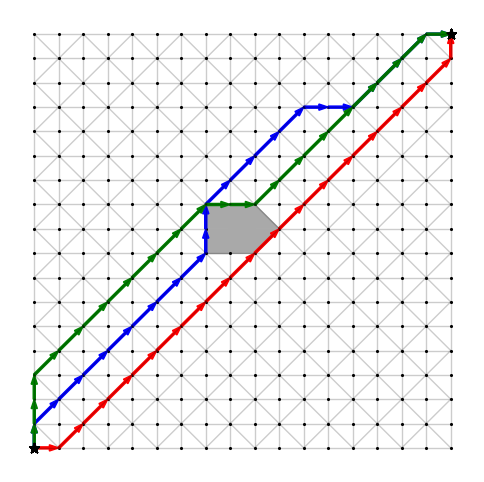

In [224]:
several_path_plot(SC, [bhat[0]] + bhat[1] + [h], ['','', ''], None, ['blue', 'red', 'green'])